(multivariate_normal_v11)=
```{raw} html
<div id="qe-notebook-header" align="right" style="text-align:right;">
        <a href="https://quantecon.org/" title="quantecon.org">
                <img style="width:250px;display:inline;" width="250px" src="https://assets.quantecon.org/img/qe-menubar-logo.svg" alt="QuantEcon">
        </a>
</div>
```

# Multivariate Normal Distribution

```{contents} Contents
:depth: 2
```

## Overview

This lecture describes a workhorse in probability theory, statistics, and economics, namely,
the **multivariate normal distribution**.

In this lecture, you will learn formulas for

* the joint distribution of a random vector $x$ of length $N$
* marginal distributions for all subvectors of $x$
* conditional distributions for subvectors of $x$ conditional on other subvectors of $x$

We will use  the multivariate normal distribution to formulate some useful models:

* a factor analytic model of an intelligence quotient, i.e., IQ
* a factor analytic model of two independent inherent abilities, say, mathematical and verbal.
* a more general factor analytic model
* Principal Components Analysis (PCA) as an approximation to a factor analytic model
* time series generated by linear stochastic difference equations
* optimal linear filtering theory

## The Multivariate Normal Distribution

This lecture defines a Python class `MultivariateNormal` to be used
to generate **marginal** and **conditional** distributions associated
with a multivariate normal distribution.

For a multivariate normal distribution it is very convenient that

- conditional expectations equal linear least squares projections
- conditional distributions are characterized by multivariate linear
  regressions

We apply our Python class to some examples.

We  use the following imports:

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (11, 5)  #set default figure size
import numpy as np
from numba import njit
import statsmodels.api as sm

Assume that an $N \times 1$ random vector $z$ has a
multivariate normal probability density.

This means that the probability density takes the form

$$
f\left(z;\mu,\Sigma\right)=\left(2\pi\right)^{-\left(\frac{N}{2}\right)}\det\left(\Sigma\right)^{-\frac{1}{2}}\exp\left(-.5\left(z-\mu\right)^{\prime}\Sigma^{-1}\left(z-\mu\right)\right)
$$

where $\mu=Ez$ is the mean of the random vector $z$ and
$\Sigma=E\left(z-\mu\right)\left(z-\mu\right)^\prime$ is the
covariance matrix of $z$.

The covariance matrix $\Sigma$ is symmetric and positive definite.

In [2]:
@njit
def f(z, μ, Σ):
    """
    The density function of multivariate normal distribution.

    Parameters
    ---------------
    z: ndarray(float, dim=2)
        random vector, N by 1
    μ: ndarray(float, dim=1 or 2)
        the mean of z, N by 1
    Σ: ndarray(float, dim=2)
        the covarianece matrix of z, N by 1
    """

    z = np.atleast_2d(z)
    μ = np.atleast_2d(μ)
    Σ = np.atleast_2d(Σ)

    N = z.size

    temp1 = np.linalg.det(Σ) ** (-1/2)
    temp2 = np.exp(-.5 * (z - μ).T @ np.linalg.inv(Σ) @ (z - μ))

    return (2 * np.pi) ** (-N/2) * temp1 * temp2

For some integer $k\in \{1,\dots, N-1\}$, partition
$z$ as

$$ 
z=\left[\begin{array}{c} z_{1}\\ z_{2} \end{array}\right],
$$

 where $z_1$ is an $\left(N-k\right)\times1$ vector and $z_2$
is a $k\times1$ vector.

Let

$$
\mu=\left[\begin{array}{c}
\mu_{1}\\
\mu_{2}
\end{array}\right],\quad\Sigma=\left[\begin{array}{cc}
\Sigma_{11} & \Sigma_{12}\\
\Sigma_{21} & \Sigma_{22}
\end{array}\right]
$$

be corresponding partitions of $\mu$ and $\Sigma$.

The **marginal** distribution of $z_1$ is

- multivariate normal with mean $\mu_1$ and covariance matrix
  $\Sigma_{11}$.

The **marginal** distribution of $z_2$ is

- multivariate normal with mean $\mu_2$ and covariance matrix
  $\Sigma_{22}$.

The distribution of $z_1$ **conditional** on $z_2$ is

- multivariate normal with mean

$$
\hat{\mu}_1 = \mu_1 + \beta \left(z_2 -\mu_2\right)
$$

and covariance matrix

$$
\hat{\Sigma}_{11}=\Sigma_{11}-\Sigma_{12}\Sigma_{22}^{-1}\Sigma_{21}=\Sigma_{11}-\beta\Sigma_{22}\beta^{\prime}
$$

where

$$
\beta = \Sigma_{12}\Sigma_{22}^{-1}
$$

is an $\left(N-k\right) \times k$ matrix of **population
regression coefficients** of the $(N -k) \times 1$ random vector $z_1 - \mu_1$ on the $k \times 1$ random vector $z_2 - \mu_2$.

The following class constructs a multivariate normal distribution
instance with two methods.

- a method `partition` computes $\beta$, taking $k$ as an
  input
- a method `cond_dist` computes either the distribution of
  $z_1$ conditional on $z_2$ or the distribution of
  $z_2$ conditional on $z_1$

In [3]:
class MultivariateNormal:
    """
    Class of multivariate normal distribution.

    Parameters
    ----------
    μ: ndarray(float, dim=1)
        the mean of z, N by 1
    Σ: ndarray(float, dim=2)
        the covarianece matrix of z, N by 1

    Arguments
    ---------
    μ, Σ:
        see parameters
    μs: list(ndarray(float, dim=1))
        list of mean vectors μ1 and μ2 in order
    Σs: list(list(ndarray(float, dim=2)))
        2 dimensional list of covariance matrices
        Σ11, Σ12, Σ21, Σ22 in order
    βs: list(ndarray(float, dim=1))
        list of regression coefficients β1 and β2 in order
    """

    def __init__(self, μ, Σ):
        "initialization"
        self.μ = np.array(μ)
        self.Σ = np.atleast_2d(Σ)

    def partition(self, k):
        """
        Given k, partition the random vector z into a size k vector z1
        and a size N-k vector z2. Partition the mean vector μ into
        μ1 and μ2, and the covariance matrix Σ into Σ11, Σ12, Σ21, Σ22
        correspondingly. Compute the regression coefficients β1 and β2
        using the partitioned arrays.
        """
        μ = self.μ
        Σ = self.Σ

        self.μs = [μ[:k], μ[k:]]
        self.Σs = [[Σ[:k, :k], Σ[:k, k:]],
                   [Σ[k:, :k], Σ[k:, k:]]]

        self.βs = [self.Σs[0][1] @ np.linalg.inv(self.Σs[1][1]),
                   self.Σs[1][0] @ np.linalg.inv(self.Σs[0][0])]

    def cond_dist(self, ind, z):
        """
        Compute the conditional distribution of z1 given z2, or reversely.
        Argument ind determines whether we compute the conditional
        distribution of z1 (ind=0) or z2 (ind=1).

        Returns
        ---------
        μ_hat: ndarray(float, ndim=1)
            The conditional mean of z1 or z2.
        Σ_hat: ndarray(float, ndim=2)
            The conditional covariance matrix of z1 or z2.
        """
        β = self.βs[ind]
        μs = self.μs
        Σs = self.Σs

        μ_hat = μs[ind] + β @ (z - μs[1-ind])
        Σ_hat = Σs[ind][ind] - β @ Σs[1-ind][1-ind] @ β.T

        return μ_hat, Σ_hat

Let’s put this code to work on a suite of examples.

We begin with a simple bivariate example; after that we’ll turn to a
trivariate example.

We’ll compute population moments of some conditional distributions using
our `MultivariateNormal` class.

For fun we’ll also compute sample analogs of the associated population
regressions by generating simulations and then computing linear least
squares regressions.

We’ll compare those linear least squares regressions for the simulated
data to their population counterparts.

## Bivariate Example

We start with a bivariate normal distribution pinned down by

$$
\mu=\left[\begin{array}{c}
.5 \\
1.0
\end{array}\right],\quad\Sigma=\left[\begin{array}{cc}
1 & .5\\
.5 & 1
\end{array}\right]
$$

In [4]:
μ = np.array([.5, 1.])
Σ = np.array([[1., .5], [.5 ,1.]])

# construction of the multivariate normal instance
multi_normal = MultivariateNormal(μ, Σ)

In [5]:
k = 1 # choose partition

# partition and compute regression coefficients
multi_normal.partition(k)
multi_normal.βs[0],multi_normal.βs[1]

(array([[0.5]]), array([[0.5]]))

Let's illustrate the fact that you _can regress anything on anything else_.

We have computed everything we need to compute two regression lines, one of $z_2$ on $z_1$, the other of $z_1$ on $z_2$.

We'll represent  these regressions as

$$
z_1 = a_1 + b_1 z_2 + \epsilon_1 
$$

and

$$ 
z_2 = a_2 + b_2 z_1 + \epsilon_2
$$

where we have the population least squares orthogonality conditions

$$
E \epsilon_1 z_2 = 0 
$$

and 

$$ 
E \epsilon_2 z_1 = 0 
$$

Let's  compute $a_1, a_2, b_1, b_2$.

In [6]:
beta = multi_normal.βs 

a1 = μ[0] - beta[0]*μ[1]
b1 = beta[0]

a2 = μ[1] - beta[1]*μ[0]
b2 = beta[1]

Let's print out the intercepts and slopes.


For the regression of $z_1$ on $z_2$ we have

In [7]:
print ("a1 = ", a1)
print ("b1 = ", b1)

a1 =  [[0.]]
b1 =  [[0.5]]


For the regression of $z_2$ on $z_1$ we have

In [8]:
print ("a2 = ", a2)
print ("b2 = ", b2)

a2 =  [[0.75]]
b2 =  [[0.5]]


Now let's plot the two regression lines and stare at them.

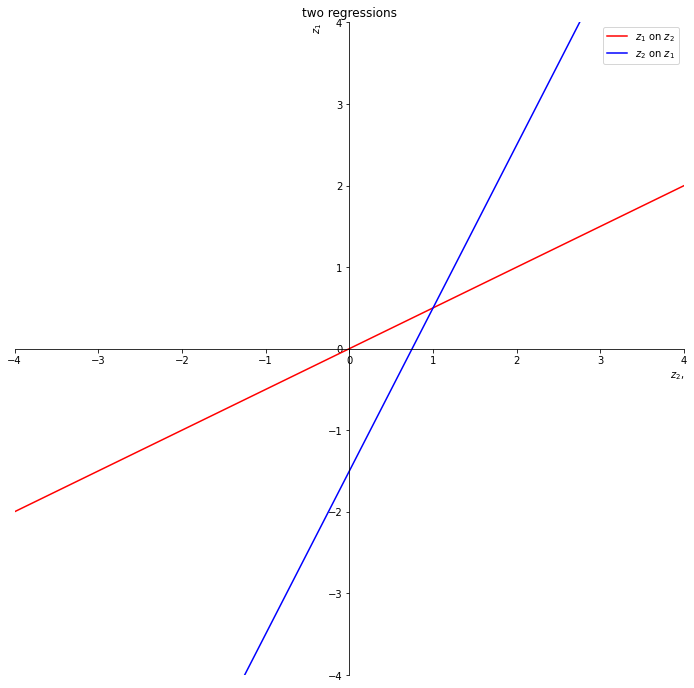

In [9]:
z2 = np.linspace(-4,4,100)


a1 = np.squeeze(a1)
b1 = np.squeeze(b1)

a2 = np.squeeze(a2)
b2 = np.squeeze(b2)

z1  = b1*z2 + a1


z1h = z2/b2 - a2/b2


fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(1, 1, 1)
ax.set(xlim=(-4, 4), ylim=(-4, 4))
ax.spines['left'].set_position('center')
ax.spines['bottom'].set_position('zero')
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
plt.ylabel('$z_1$', loc = 'top')
plt.xlabel('$z_2$,', loc = 'right')
plt.title('two regressions')
plt.plot(z2,z1, 'r', label = "$z_1$ on $z_2$")
plt.plot(z2,z1h, 'b', label = "$z_2$ on $z_1$")
plt.legend()
plt.show()

The red line is the  expectation of $z_1$ conditional on $z_2$.

The intercept and slope of the red line are

In [10]:
print("a1 = ", a1)
print("b1 = ", b1)

a1 =  0.0
b1 =  0.5


The blue line is the expectation of $z_2$ conditional on $z_1$.  

The intercept and slope of the blue line are

In [11]:
print("-a2/b2 = ", - a2/b2)
print("1/b2 = ", 1/b2)

-a2/b2 =  -1.5
1/b2 =  2.0


We can use these regression lines or our code to compute conditional expectations.

Let's  compute the mean and variance of the distribution of $z_2$
conditional on $z_1=5$.

After that we'll reverse what are on the left and right sides of the regression.

In [12]:
# compute the cond. dist. of z1
ind = 1
z1 = np.array([5.]) # given z1

μ2_hat, Σ2_hat = multi_normal.cond_dist(ind, z1)
print('μ2_hat, Σ2_hat = ', μ2_hat, Σ2_hat)

μ2_hat, Σ2_hat =  [3.25] [[0.75]]


Now let’s compute the mean and variance of the distribution of $z_1$
conditional on $z_2=5$.

In [13]:
# compute the cond. dist. of z1
ind = 0
z2 = np.array([5.]) # given z2

μ1_hat, Σ1_hat = multi_normal.cond_dist(ind, z2)
print('μ1_hat, Σ1_hat = ', μ1_hat, Σ1_hat)

μ1_hat, Σ1_hat =  [2.5] [[0.75]]


Let’s compare the preceding population mean and variance with outcomes
from drawing a large sample and then regressing $z_1 - \mu_1$ on
$z_2 - \mu_2$.

We know that

$$
E z_1 | z_2 = \left(\mu_1 - \beta \mu_2 \right) + \beta z_2
$$

which can be arranged to

$$
z_1 - \mu_1 = \beta \left( z_2 - \mu_2 \right) + \epsilon,
$$

We anticipate that for larger and larger sample sizes, estimated OLS
coefficients will converge to $\beta$ and the estimated variance
of $\epsilon$ will converge to $\hat{\Sigma}_1$.

In [14]:
n = 1_000_000 # sample size

# simulate multivariate normal random vectors
data = np.random.multivariate_normal(μ, Σ, size=n)
z1_data = data[:, 0]
z2_data = data[:, 1]

# OLS regression
μ1, μ2 = multi_normal.μs
results = sm.OLS(z1_data - μ1, z2_data - μ2).fit()

Let’s compare the preceding population $\beta$ with the OLS sample
estimate on $z_2 - \mu_2$

In [15]:
multi_normal.βs[0], results.params

(array([[0.5]]), array([0.49888438]))

Let’s compare our population $\hat{\Sigma}_1$ with the
degrees-of-freedom adjusted estimate of the variance of $\epsilon$

In [16]:
Σ1_hat, results.resid @ results.resid.T / (n - 1)

(array([[0.75]]), 0.7489762553652597)

Lastly, let’s compute the estimate of $\hat{E z_1 | z_2}$ and
compare it with $\hat{\mu}_1$

In [17]:
μ1_hat, results.predict(z2 - μ2) + μ1

(array([2.5]), array([2.49553753]))

Thus, in each case, for our very large sample size, the sample analogues
closely approximate their population counterparts.

A Law of Large
Numbers explains why  sample analogues approximate  population objects.

## Trivariate Example

Let’s apply our code to a trivariate example.

We’ll specify the mean vector and the covariance matrix as follows.

In [18]:
μ = np.random.random(3)
C = np.random.random((3, 3))
Σ = C @ C.T # positive semi-definite

multi_normal = MultivariateNormal(μ, Σ)

In [19]:
μ, Σ

(array([0.92810286, 0.85917131, 0.59285666]),
 array([[1.44467276, 1.32584492, 0.88971103],
        [1.32584492, 1.42856827, 0.7807192 ],
        [0.88971103, 0.7807192 , 0.55481884]]))

In [20]:
k = 1
multi_normal.partition(k)

Let’s compute the distribution of $z_1$ conditional on
$z_{2}=\left[\begin{array}{c} 2\\ 5 \end{array}\right]$.

In [21]:
ind = 0
z2 = np.array([2., 5.])

μ1_hat, Σ1_hat = multi_normal.cond_dist(ind, z2)

In [22]:
n = 1_000_000
data = np.random.multivariate_normal(μ, Σ, size=n)
z1_data = data[:, :k]
z2_data = data[:, k:]

In [23]:
μ1, μ2 = multi_normal.μs
results = sm.OLS(z1_data - μ1, z2_data - μ2).fit()

As above, we compare population and sample regression coefficients, the
conditional covariance matrix, and the conditional mean vector in that
order.

In [24]:
multi_normal.βs[0], results.params

(array([[0.22389433, 1.28855111]]), array([0.22393033, 1.28845338]))

In [25]:
Σ1_hat, results.resid @ results.resid.T / (n - 1)

(array([[0.00138547]]), 0.001388166113415843)

In [26]:
μ1_hat, results.predict(z2 - μ2) + μ1

(array([6.86235737]), array([6.86196772]))

Once again, sample analogues do a good job of approximating their
populations counterparts.

## One Dimensional Intelligence (IQ)

Let’s move closer to a real-life example, namely, inferring a
one-dimensional measure of intelligence called IQ from a list of test
scores.

The $i$th test score $y_i$ equals the sum of an unknown
scalar IQ $\theta$ and a random variable $w_{i}$.

$$
y_{i} = \theta + \sigma_y w_i, \quad i=1,\dots, n
$$

The distribution of IQ’s for a cross-section of people is a normal
random variable described by

$$
\theta = \mu_{\theta} + \sigma_{\theta} w_{n+1}.
$$

We assume that the noises $\{w_i\}_{i=1}^N$  in the test scores are IID and not correlated with
IQ.

We also assume that $\{w_i\}_{i=1}^{n+1}$ are i.i.d. standard
normal:

$$
\boldsymbol{w}=
\left[\begin{array}{c}
w_{1}\\
w_{2}\\
\vdots\\
w_{n}\\
w_{n+1}
\end{array}\right]\sim N\left(0,I_{n+1}\right)
$$

The following system describes the $(n+1) \times 1$ random vector $X$ that
interests us:

$$
X=\left[\begin{array}{c}
y_{1}\\
y_{2}\\
\vdots\\
y_{n}\\
\theta
\end{array}\right]=\left[\begin{array}{c}
\mu_{\theta}\\
\mu_{\theta}\\
\vdots\\
\mu_{\theta}\\
\mu_{\theta}
\end{array}\right]+\left[\begin{array}{ccccc}
\sigma_{y} & 0 & \cdots & 0 & \sigma_{\theta}\\
0 & \sigma_{y} & \cdots & 0 & \sigma_{\theta}\\
\vdots & \vdots & \ddots & \vdots & \vdots\\
0 & 0 & \cdots & \sigma_{y} & \sigma_{\theta}\\
0 & 0 & \cdots & 0 & \sigma_{\theta}
\end{array}\right]\left[\begin{array}{c}
w_{1}\\
w_{2}\\
\vdots\\
w_{n}\\
w_{n+1}
\end{array}\right],
$$

or equivalently,

$$
X=\mu_{\theta}\boldsymbol{1}_{n+1}+D\boldsymbol{w}
$$

where $X = \begin{bmatrix} y \cr \theta \end{bmatrix}$,
$\boldsymbol{1}_{n+1}$ is a vector of $1$s of size
$n+1$, and $D$ is an $n+1$ by $n+1$ matrix.

Let’s define a Python function that constructs the mean $\mu$ and
covariance matrix $\Sigma$ of the random vector $X$ that we
know is governed by a multivariate normal distribution.

As arguments, the function takes the number of tests $n$, the mean
$\mu_{\theta}$ and the standard deviation $\sigma_\theta$ of
the IQ distribution, and the standard deviation of the randomness in
test scores $\sigma_{y}$.

In [27]:
def construct_moments_IQ(n, μθ, σθ, σy):

    μ_IQ = np.full(n+1, μθ)

    D_IQ = np.zeros((n+1, n+1))
    D_IQ[range(n), range(n)] = σy
    D_IQ[:, n] = σθ

    Σ_IQ = D_IQ @ D_IQ.T

    return μ_IQ, Σ_IQ, D_IQ

Now let’s consider a specific instance of this model.

Assume we have recorded $50$ test scores and we know that
$\mu_{\theta}=100$, $\sigma_{\theta}=10$, and
$\sigma_{y}=10$.

We can compute the mean vector and covariance matrix of $X$ easily
with our `construct_moments_IQ` function as follows.

In [28]:
n = 50
μθ, σθ, σy = 100., 10., 10.

μ_IQ, Σ_IQ, D_IQ = construct_moments_IQ(n, μθ, σθ, σy)
μ_IQ, Σ_IQ, D_IQ

(array([100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
        100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
        100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
        100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
        100., 100., 100., 100., 100., 100., 100.]),
 array([[200., 100., 100., ..., 100., 100., 100.],
        [100., 200., 100., ..., 100., 100., 100.],
        [100., 100., 200., ..., 100., 100., 100.],
        ...,
        [100., 100., 100., ..., 200., 100., 100.],
        [100., 100., 100., ..., 100., 200., 100.],
        [100., 100., 100., ..., 100., 100., 100.]]),
 array([[10.,  0.,  0., ...,  0.,  0., 10.],
        [ 0., 10.,  0., ...,  0.,  0., 10.],
        [ 0.,  0., 10., ...,  0.,  0., 10.],
        ...,
        [ 0.,  0.,  0., ..., 10.,  0., 10.],
        [ 0.,  0.,  0., ...,  0., 10., 10.],
        [ 0.,  0.,  0., ...,  0.,  0., 10.]]))

We can now use our `MultivariateNormal` class to construct an
instance, then partition the mean vector and covariance matrix as we
wish.

We want to regress IQ, the random variable $\theta$ (_what we don't know_), on the vector $y$  of test scores (_what we do know_). 

We choose `k=n` so that $z_{1} = y$ and $z_{2} = \theta$.

In [29]:
multi_normal_IQ = MultivariateNormal(μ_IQ, Σ_IQ)

k = n
multi_normal_IQ.partition(k)

Using the generator `multivariate_normal`, we can make one draw of the
random vector from our distribution and then compute the distribution of
$\theta$ conditional on our test scores.

Let’s do that and then print out some pertinent quantities.

In [30]:
x = np.random.multivariate_normal(μ_IQ, Σ_IQ)
y = x[:-1] # test scores
θ = x[-1]  # IQ

In [31]:
# the true value
θ

103.03684730693615

The method `cond_dist` takes test scores $y$ as input and returns the
conditional normal distribution of the IQ $\theta$.

In the following code, `ind` sets the variables on the right side of the regression.

Given the way we have defined the vector $X$, we want  to set `ind=1` in order to make $\theta$ the left side variable in the
population regression.

In [32]:
ind = 1
multi_normal_IQ.cond_dist(ind, y)

(array([104.70018421]), array([[1.96078431]]))

The first number is the conditional mean $\hat{\mu}_{\theta}$ and
the second is the conditional variance $\hat{\Sigma}_{\theta}$.

How do additional test scores affect our inferences?

To shed light on this, we compute a sequence of conditional
distributions of $\theta$ by varying the number of test scores in
the conditioning set from $1$ to $n$.

We’ll make a pretty graph showing how our judgment of the person’s IQ
change as more test results come in.

In [33]:
# array for containing moments
μθ_hat_arr = np.empty(n)
Σθ_hat_arr = np.empty(n)

# loop over number of test scores
for i in range(1, n+1):
    # construction of multivariate normal distribution instance
    μ_IQ_i, Σ_IQ_i, D_IQ_i = construct_moments_IQ(i, μθ, σθ, σy)
    multi_normal_IQ_i = MultivariateNormal(μ_IQ_i, Σ_IQ_i)

    # partition and compute conditional distribution
    multi_normal_IQ_i.partition(i)
    scores_i = y[:i]
    μθ_hat_i, Σθ_hat_i = multi_normal_IQ_i.cond_dist(1, scores_i)

    # store the results
    μθ_hat_arr[i-1] = μθ_hat_i[0]
    Σθ_hat_arr[i-1] = Σθ_hat_i[0, 0]

# transform variance to standard deviation
σθ_hat_arr = np.sqrt(Σθ_hat_arr)

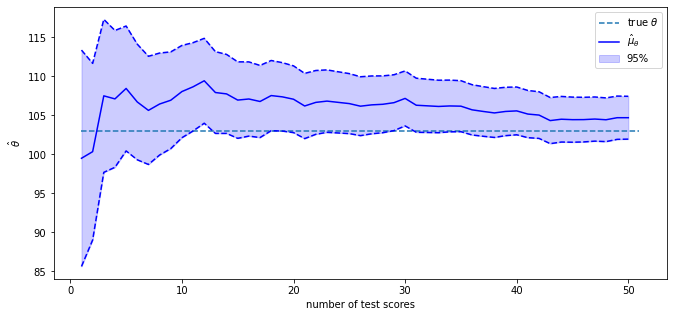

In [34]:
μθ_hat_lower = μθ_hat_arr - 1.96 * σθ_hat_arr
μθ_hat_higher = μθ_hat_arr + 1.96 * σθ_hat_arr

plt.hlines(θ, 1, n+1, ls='--', label='true $θ$')
plt.plot(range(1, n+1), μθ_hat_arr, color='b', label='$\hat{μ}_{θ}$')
plt.plot(range(1, n+1), μθ_hat_lower, color='b', ls='--')
plt.plot(range(1, n+1), μθ_hat_higher, color='b', ls='--')
plt.fill_between(range(1, n+1), μθ_hat_lower, μθ_hat_higher,
                 color='b', alpha=0.2, label='95%')

plt.xlabel('number of test scores')
plt.ylabel('$\hat{θ}$')
plt.legend()

plt.show()

The solid blue line in the plot above shows $\hat{\mu}_{\theta}$
as a function of the number of test scores that we have recorded and
conditioned on.

The blue area shows the span that comes from adding or deducing
$1.96 \hat{\sigma}_{\theta}$ from $\hat{\mu}_{\theta}$.

Therefore, $95\%$ of the probability mass of the conditional
distribution falls in this range.

The value of the random $\theta$ that we drew is shown by the
black dotted line.

As more and more test scores come in, our estimate of the person’s
$\theta$ become more and more reliable.

By staring at the changes in the conditional distributions, we see that
adding more test scores makes $\hat{\theta}$ settle down and
approach $\theta$.

Thus, each $y_{i}$ adds information about $\theta$.

If we were to drive the number of tests $n \rightarrow + \infty$, the
conditional standard deviation $\hat{\sigma}_{\theta}$ would
converge to $0$ at  rate $\frac{1}{n^{.5}}$.

## Information as Surprise

By using a different representation, let’s look at things from a
different perspective.

We can represent the random vector $X$ defined above as

$$
X = \mu_{\theta} \boldsymbol{1}_{n+1} + C \epsilon, \quad \epsilon \sim N\left(0, I\right)
$$

where $C$ is a lower triangular **Cholesky factor** of
$\Sigma$ so that

$$
\Sigma \equiv DD^{\prime} = C C^\prime
$$

and

$$
E \epsilon \epsilon' = I .
$$

It follows that

$$
\epsilon \sim N(0, I) .
$$

Let $G=C^{-1}$

$G$ is also lower triangular.

We can compute $\epsilon$ from the formula

$$
\epsilon = G \left( X - \mu_{\theta} \boldsymbol{1}_{n+1} \right)
$$

This formula confirms that the orthonormal vector $\epsilon$
contains the same information as the non-orthogonal vector
$\left( X - \mu_{\theta} \boldsymbol{1}_{n+1} \right)$.

We can say that $\epsilon$ is an orthogonal basis for
$\left( X - \mu_{\theta} \boldsymbol{1}_{n+1} \right)$.

Let $c_{i}$ be the $i$th element in the last row of
$C$.

Then we can write

```{math}
:label: mnv_1

\theta = \mu_{\theta} + c_1 \epsilon_1 + c_2 \epsilon_2 + \dots + c_n \epsilon_n + c_{n+1} \epsilon_{n+1}
```

The mutual orthogonality of the $\epsilon_i$’s provides us with an
informative way to interpret them in light of equation {eq}`mnv_1`.

Thus, relative to what is known from tests $i=1, \ldots, n-1$,
$c_i \epsilon_i$ is the amount of **new information** about
$\theta$ brought by the test number $i$.

Here **new information** means **surprise** or what could not be
predicted from earlier information.

Formula {eq}`mnv_1` also provides us with an enlightening way to express
conditional means and conditional variances that we computed earlier.

In particular,

$$
E\left[\theta \mid y_1, \dots, y_k\right] = \mu_{\theta} + c_1 \epsilon_1 + \dots + c_k \epsilon_k
$$

and

$$
Var\left(\theta \mid y_1, \dots, y_k\right) = c^2_{k+1} + c^2_{k+2} + \dots + c^2_{n+1}.
$$

In [35]:
C = np.linalg.cholesky(Σ_IQ)
G = np.linalg.inv(C)

ε = G @ (x - μθ)

In [36]:
cε = C[n, :] * ε

# compute the sequence of μθ and Σθ conditional on y1, y2, ..., yk
μθ_hat_arr_C = np.array([np.sum(cε[:k+1]) for k in range(n)]) + μθ
Σθ_hat_arr_C = np.array([np.sum(C[n, i+1:n+1] ** 2) for i in range(n)])

To confirm that these formulas give the same answers that we computed
earlier, we can compare the means and variances of $\theta$
conditional on $\{y_i\}_{i=1}^k$ with what we obtained above using
the formulas implemented in the class `MultivariateNormal` built on
our original representation of conditional distributions for
multivariate normal distributions.

In [37]:
# conditional mean
np.max(np.abs(μθ_hat_arr - μθ_hat_arr_C)) < 1e-10

True

In [38]:
# conditional variance
np.max(np.abs(Σθ_hat_arr - Σθ_hat_arr_C)) < 1e-10

True

## Cholesky Factor Magic

Evidently, the Cholesky factorizations automatically computes the
population  **regression coefficients** and associated statistics
that are produced by our `MultivariateNormal` class.

The Cholesky factorization  computes these things **recursively**.

Indeed, in formula {eq}`mnv_1`,

- the random variable $c_i \epsilon_i$ is information about
  $\theta$ that is not contained by the information in
  $\epsilon_1, \epsilon_2, \ldots, \epsilon_{i-1}$
- the coefficient $c_i$ is the simple population regression
  coefficient of $\theta - \mu_\theta$ on $\epsilon_i$

## Math and Verbal  Intelligence

We can alter the preceding example to be more realistic.

There is ample evidence that IQ is not a scalar.

Some people are good in math skills but poor in language skills.

Other people are good in language skills but poor in math skills.

So now we shall assume that there are two dimensions of IQ,
$\theta$ and $\eta$.

These determine average performances in math and language tests,
respectively.

We observe math scores $\{y_i\}_{i=1}^{n}$ and language scores
$\{y_i\}_{i=n+1}^{2n}$.

When $n=2$, we assume that outcomes are draws from a multivariate
normal distribution with representation

$$
X=\left[\begin{array}{c}
y_{1}\\
y_{2}\\
y_{3}\\
y_{4}\\
\theta\\
\eta
\end{array}\right]=\left[\begin{array}{c}
\mu_{\theta}\\
\mu_{\theta}\\
\mu_{\eta}\\
\mu_{\eta}\\
\mu_{\theta}\\
\mu_{\eta}
\end{array}\right]+\left[\begin{array}{cccccc}
\sigma_{y} & 0 & 0 & 0 & \sigma_{\theta} & 0\\
0 & \sigma_{y} & 0 & 0 & \sigma_{\theta} & 0\\
0 & 0 & \sigma_{y} & 0 & 0 & \sigma_{\eta}\\
0 & 0 & 0 & \sigma_{y} & 0 & \sigma_{\eta}\\
0 & 0 & 0 & 0 & \sigma_{\theta} & 0\\
0 & 0 & 0 & 0 & 0 & \sigma_{\eta}
\end{array}\right]\left[\begin{array}{c}
w_{1}\\
w_{2}\\
w_{3}\\
w_{4}\\
w_{5}\\
w_{6}
\end{array}\right]
$$

where
$w \begin{bmatrix} w_1 \cr w_2 \cr \vdots \cr w_6 \end{bmatrix}$
is a standard normal random vector.

We construct a Python function `construct_moments_IQ2d` to construct
the mean vector and covariance matrix of the joint normal distribution.

In [39]:
def construct_moments_IQ2d(n, μθ, σθ, μη, ση, σy):

    μ_IQ2d = np.empty(2*(n+1))
    μ_IQ2d[:n] = μθ
    μ_IQ2d[2*n] = μθ
    μ_IQ2d[n:2*n] = μη
    μ_IQ2d[2*n+1] = μη


    D_IQ2d = np.zeros((2*(n+1), 2*(n+1)))
    D_IQ2d[range(2*n), range(2*n)] = σy
    D_IQ2d[:n, 2*n] = σθ
    D_IQ2d[2*n, 2*n] = σθ
    D_IQ2d[n:2*n, 2*n+1] = ση
    D_IQ2d[2*n+1, 2*n+1] = ση

    Σ_IQ2d = D_IQ2d @ D_IQ2d.T

    return μ_IQ2d, Σ_IQ2d, D_IQ2d

Let’s put the function to work.

In [40]:
n = 2
# mean and variance of θ, η, and y
μθ, σθ, μη, ση, σy = 100., 10., 100., 10, 10

μ_IQ2d, Σ_IQ2d, D_IQ2d = construct_moments_IQ2d(n, μθ, σθ, μη, ση, σy)
μ_IQ2d, Σ_IQ2d, D_IQ2d

(array([100., 100., 100., 100., 100., 100.]),
 array([[200., 100.,   0.,   0., 100.,   0.],
        [100., 200.,   0.,   0., 100.,   0.],
        [  0.,   0., 200., 100.,   0., 100.],
        [  0.,   0., 100., 200.,   0., 100.],
        [100., 100.,   0.,   0., 100.,   0.],
        [  0.,   0., 100., 100.,   0., 100.]]),
 array([[10.,  0.,  0.,  0., 10.,  0.],
        [ 0., 10.,  0.,  0., 10.,  0.],
        [ 0.,  0., 10.,  0.,  0., 10.],
        [ 0.,  0.,  0., 10.,  0., 10.],
        [ 0.,  0.,  0.,  0., 10.,  0.],
        [ 0.,  0.,  0.,  0.,  0., 10.]]))

In [41]:
# take one draw
x = np.random.multivariate_normal(μ_IQ2d, Σ_IQ2d)
y1 = x[:n]
y2 = x[n:2*n]
θ = x[2*n]
η = x[2*n+1]

# the true values
θ, η

(106.4626319471015, 103.72220442481496)

We first compute the joint normal distribution of
$\left(\theta, \eta\right)$.

In [42]:
multi_normal_IQ2d = MultivariateNormal(μ_IQ2d, Σ_IQ2d)

k = 2*n # the length of data vector
multi_normal_IQ2d.partition(k)

multi_normal_IQ2d.cond_dist(1, [*y1, *y2])

(array([104.39510104, 108.33533282]),
 array([[33.33333333,  0.        ],
        [ 0.        , 33.33333333]]))

Now let’s compute distributions of $\theta$ and $\mu$
separately conditional on various subsets of test scores.

It will be fun to compare outcomes with the help of an auxiliary function
`cond_dist_IQ2d` that we now construct.

In [43]:
def cond_dist_IQ2d(μ, Σ, data):

    n = len(μ)

    multi_normal = MultivariateNormal(μ, Σ)
    multi_normal.partition(n-1)
    μ_hat, Σ_hat = multi_normal.cond_dist(1, data)

    return μ_hat, Σ_hat

Let’s see how things work for an example.

In [44]:
for indices, IQ, conditions in [([*range(2*n), 2*n], 'θ', 'y1, y2, y3, y4'),
                                ([*range(n), 2*n], 'θ', 'y1, y2'),
                                ([*range(n, 2*n), 2*n], 'θ', 'y3, y4'),
                                ([*range(2*n), 2*n+1], 'η', 'y1, y2, y3, y4'),
                                ([*range(n), 2*n+1], 'η', 'y1, y2'),
                                ([*range(n, 2*n), 2*n+1], 'η', 'y3, y4')]:

    μ_hat, Σ_hat = cond_dist_IQ2d(μ_IQ2d[indices], Σ_IQ2d[indices][:, indices], x[indices[:-1]])
    print(f'The mean and variance of {IQ} conditional on {conditions: <15} are ' +
          f'{μ_hat[0]:1.2f} and {Σ_hat[0, 0]:1.2f} respectively')

The mean and variance of θ conditional on y1, y2, y3, y4  are 104.40 and 33.33 respectively
The mean and variance of θ conditional on y1, y2          are 104.40 and 33.33 respectively
The mean and variance of θ conditional on y3, y4          are 100.00 and 100.00 respectively
The mean and variance of η conditional on y1, y2, y3, y4  are 108.34 and 33.33 respectively
The mean and variance of η conditional on y1, y2          are 100.00 and 100.00 respectively
The mean and variance of η conditional on y3, y4          are 108.34 and 33.33 respectively


Evidently, math tests provide no information about $\mu$ and
language tests provide no information about $\eta$.

## Univariate Time Series Analysis

We can use the multivariate normal distribution and a little matrix
algebra to present foundations of univariate linear time series
analysis.

Let $x_t, y_t, v_t, w_{t+1}$ each be scalars for $t \geq 0$.

Consider the following model:

$$
\begin{aligned}
x_0 & \sim  N\left(0, \sigma_0^2\right) \\
x_{t+1} & = a x_{t} + b w_{t+1}, \quad w_{t+1} \sim N\left(0, 1\right), t \geq 0  \\
y_{t} & = c x_{t} + d v_{t}, \quad v_{t} \sim N\left(0, 1\right), t \geq 0
\end{aligned}
$$

We can compute the moments of $x_{t}$

1. $E x_{t+1}^2 = a^2 E x_{t}^2 + b^2, t \geq 0$, where
   $E x_{0}^2 = \sigma_{0}^2$
1. $E x_{t+j} x_{t} = a^{j} E x_{t}^2, \forall t \ \forall j$

Given some $T$, we can formulate the sequence
$\{x_{t}\}_{t=0}^T$ as a random vector

$$
X=\left[\begin{array}{c}
x_{0}\\
x_{1}\\
\vdots\\
x_{T}
\end{array}\right]
$$

and the covariance matrix $\Sigma_{x}$ can be constructed using
the moments we have computed above.

Similarly, we can define

$$
Y=\left[\begin{array}{c}
y_{0}\\
y_{1}\\
\vdots\\
y_{T}
\end{array}\right], \quad
v=\left[\begin{array}{c}
v_{0}\\
v_{1}\\
\vdots\\
v_{T}
\end{array}\right]
$$

and therefore

$$
Y = C X + D V
$$

where $C$ and $D$ are both diagonal matrices with constant
$c$ and $d$ as diagonal respectively.

Consequently, the covariance matrix of $Y$ is

$$
\Sigma_{y} = E Y Y^{\prime} = C \Sigma_{x} C^{\prime} + D D^{\prime}
$$

By stacking $X$ and $Y$, we can write

$$
Z=\left[\begin{array}{c}
X\\
Y
\end{array}\right]
$$

and

$$
\Sigma_{z} = EZZ^{\prime}=\left[\begin{array}{cc}
\Sigma_{x} & \Sigma_{x}C^{\prime}\\
C\Sigma_{x} & \Sigma_{y}
\end{array}\right]
$$

Thus, the stacked sequences $\{x_{t}\}_{t=0}^T$ and
$\{y_{t}\}_{t=0}^T$ jointly follow the multivariate normal
distribution $N\left(0, \Sigma_{z}\right)$.

In [45]:
# as an example, consider the case where T = 3
T = 3

In [46]:
# variance of the initial distribution x_0
σ0 = 1.

# parameters of the equation system
a = .9
b = 1.
c = 1.0
d = .05

In [47]:
# construct the covariance matrix of X
Σx = np.empty((T+1, T+1))

Σx[0, 0] = σ0 ** 2
for i in range(T):
    Σx[i, i+1:] = Σx[i, i] * a ** np.arange(1, T+1-i)
    Σx[i+1:, i] = Σx[i, i+1:]

    Σx[i+1, i+1] = a ** 2 * Σx[i, i] + b ** 2

In [48]:
Σx

array([[1.      , 0.9     , 0.81    , 0.729   ],
       [0.9     , 1.81    , 1.629   , 1.4661  ],
       [0.81    , 1.629   , 2.4661  , 2.21949 ],
       [0.729   , 1.4661  , 2.21949 , 2.997541]])

In [49]:
# construct the covariance matrix of Y
C = np.eye(T+1) * c
D = np.eye(T+1) * d

Σy = C @ Σx @ C.T + D @ D.T

In [50]:
# construct the covariance matrix of Z
Σz = np.empty((2*(T+1), 2*(T+1)))

Σz[:T+1, :T+1] = Σx
Σz[:T+1, T+1:] = Σx @ C.T
Σz[T+1:, :T+1] = C @ Σx
Σz[T+1:, T+1:] = Σy

In [51]:
Σz

array([[1.      , 0.9     , 0.81    , 0.729   , 1.      , 0.9     ,
        0.81    , 0.729   ],
       [0.9     , 1.81    , 1.629   , 1.4661  , 0.9     , 1.81    ,
        1.629   , 1.4661  ],
       [0.81    , 1.629   , 2.4661  , 2.21949 , 0.81    , 1.629   ,
        2.4661  , 2.21949 ],
       [0.729   , 1.4661  , 2.21949 , 2.997541, 0.729   , 1.4661  ,
        2.21949 , 2.997541],
       [1.      , 0.9     , 0.81    , 0.729   , 1.0025  , 0.9     ,
        0.81    , 0.729   ],
       [0.9     , 1.81    , 1.629   , 1.4661  , 0.9     , 1.8125  ,
        1.629   , 1.4661  ],
       [0.81    , 1.629   , 2.4661  , 2.21949 , 0.81    , 1.629   ,
        2.4686  , 2.21949 ],
       [0.729   , 1.4661  , 2.21949 , 2.997541, 0.729   , 1.4661  ,
        2.21949 , 3.000041]])

In [52]:
# construct the mean vector of Z
μz = np.zeros(2*(T+1))

The following Python code lets us sample random vectors $X$ and
$Y$.

This is going to be very useful for doing the conditioning to be used in
the fun exercises below.

In [53]:
z = np.random.multivariate_normal(μz, Σz)

x = z[:T+1]
y = z[T+1:]

### Smoothing Example

This is an instance of a classic `smoothing` calculation whose purpose
is to compute $E X \mid Y$.

An interpretation of this example is

- $X$ is a random sequence of hidden Markov state variables
  $x_t$
- $Y$ is a sequence of observed signals $y_t$ bearing
  information about the hidden state

In [54]:
# construct a MultivariateNormal instance
multi_normal_ex1 = MultivariateNormal(μz, Σz)
x = z[:T+1]
y = z[T+1:]

In [55]:
# partition Z into X and Y
multi_normal_ex1.partition(T+1)

In [56]:
# compute the conditional mean and covariance matrix of X given Y=y

print("X = ", x)
print("Y = ", y)
print(" E [ X | Y] = ", )

multi_normal_ex1.cond_dist(0, y)

X =  [ 0.29838281  0.14533093 -0.37349005 -0.60903333]
Y =  [ 0.35383805  0.02701783 -0.40312056 -0.55368278]
 E [ X | Y] = 


(array([ 0.35230414,  0.02678373, -0.40248377, -0.55320535]),
 array([[2.48875094e-03, 5.57449314e-06, 1.24861729e-08, 2.80235835e-11],
        [5.57449314e-06, 2.48876343e-03, 5.57452116e-06, 1.25113941e-08],
        [1.24861729e-08, 5.57452116e-06, 2.48876346e-03, 5.58575339e-06],
        [2.80235835e-11, 1.25113941e-08, 5.58575339e-06, 2.49377812e-03]]))

### Filtering Exercise

Compute $E\left[x_{t} \mid y_{t-1}, y_{t-2}, \dots, y_{0}\right]$.

To do so, we need to first construct the mean vector and the covariance
matrix of the subvector
$\left[x_{t}, y_{0}, \dots, y_{t-2}, y_{t-1}\right]$.

For example, let’s say that we want the conditional distribution of
$x_{3}$.

In [57]:
t = 3

In [58]:
# mean of the subvector
sub_μz = np.zeros(t+1)

# covariance matrix of the subvector
sub_Σz = np.empty((t+1, t+1))

sub_Σz[0, 0] = Σz[t, t] # x_t
sub_Σz[0, 1:] = Σz[t, T+1:T+t+1]
sub_Σz[1:, 0] = Σz[T+1:T+t+1, t]
sub_Σz[1:, 1:] = Σz[T+1:T+t+1, T+1:T+t+1]

In [59]:
sub_Σz

array([[2.997541, 0.729   , 1.4661  , 2.21949 ],
       [0.729   , 1.0025  , 0.9     , 0.81    ],
       [1.4661  , 0.9     , 1.8125  , 1.629   ],
       [2.21949 , 0.81    , 1.629   , 2.4686  ]])

In [60]:
multi_normal_ex2 = MultivariateNormal(sub_μz, sub_Σz)
multi_normal_ex2.partition(1)

In [61]:
sub_y = y[:t]

multi_normal_ex2.cond_dist(0, sub_y)

(array([-0.36184965]), array([[1.00201996]]))

### Prediction Exercise

Compute $E\left[y_{t} \mid y_{t-j}, \dots, y_{0} \right]$.

As what we did in exercise 2, we will construct the mean vector and
covariance matrix of the subvector
$\left[y_{t}, y_{0}, \dots, y_{t-j-1}, y_{t-j} \right]$.

For example, we take a case in which $t=3$ and $j=2$.

In [62]:
t = 3
j = 2

In [63]:
sub_μz = np.zeros(t-j+2)
sub_Σz = np.empty((t-j+2, t-j+2))

sub_Σz[0, 0] = Σz[T+t+1, T+t+1]
sub_Σz[0, 1:] = Σz[T+t+1, T+1:T+t-j+2]
sub_Σz[1:, 0] = Σz[T+1:T+t-j+2, T+t+1]
sub_Σz[1:, 1:] = Σz[T+1:T+t-j+2, T+1:T+t-j+2]

In [64]:
sub_Σz

array([[3.000041, 0.729   , 1.4661  ],
       [0.729   , 1.0025  , 0.9     ],
       [1.4661  , 0.9     , 1.8125  ]])

In [65]:
multi_normal_ex3 = MultivariateNormal(sub_μz, sub_Σz)
multi_normal_ex3.partition(1)

In [66]:
sub_y = y[:t-j+1]

multi_normal_ex3.cond_dist(0, sub_y)

(array([0.02247034]), array([[1.81413617]]))

### Constructing a Wold Representation

Now we’ll apply Cholesky decomposition to decompose
$\Sigma_{y}=H H^{\prime}$ and form

$$
\epsilon = H^{-1} Y.
$$

Then we can represent $y_{t}$ as

$$
y_{t} = h_{t,t} \epsilon_{t} + h_{t,t-1} \epsilon_{t-1} + \dots + h_{t,0} \epsilon_{0}.
$$

In [67]:
H = np.linalg.cholesky(Σy)

H

array([[1.00124922, 0.        , 0.        , 0.        ],
       [0.8988771 , 1.00225743, 0.        , 0.        ],
       [0.80898939, 0.89978675, 1.00225743, 0.        ],
       [0.72809046, 0.80980808, 0.89978676, 1.00225743]])

In [68]:
ε = np.linalg.inv(H) @ y

ε

array([ 0.35339658, -0.28998764, -0.42712341, -0.19140106])

In [69]:
y

array([ 0.35383805,  0.02701783, -0.40312056, -0.55368278])

This example is an instance of what is known as a **Wold representation** in time series analysis.


## Stochastic Difference Equation

Consider the stochastic second-order linear difference equation

$$
y_{t} = \alpha_{0} + \alpha_{1} y_{y-1} + \alpha_{2} y_{t-2} + u_{t}
$$

where $u_{t} \sim N \left(0, \sigma_{u}^{2}\right)$ and

$$
\left[\begin{array}{c}
y_{-1}\\
y_{0}
\end{array}\right]\sim N\left(\mu_{\tilde{y}},\Sigma_{\tilde{y}}\right)
$$

It can be written as a stacked system

$$
\underset{\equiv A}{\underbrace{\left[\begin{array}{cccccccc}
1 & 0 & 0 & 0 & \cdots & 0 & 0 & 0\\
-\alpha_{1} & 1 & 0 & 0 & \cdots & 0 & 0 & 0\\
-\alpha_{2} & -\alpha_{1} & 1 & 0 & \cdots & 0 & 0 & 0\\
0 & -\alpha_{2} & -\alpha_{1} & 1 & \cdots & 0 & 0 & 0\\
\vdots & \vdots & \vdots & \vdots & \cdots & \vdots & \vdots & \vdots\\
0 & 0 & 0 & 0 & \cdots & -\alpha_{2} & -\alpha_{1} & 1
\end{array}\right]}}\left[\begin{array}{c}
y_{1}\\
y_{2}\\
y_{3}\\
y_{4}\\
\vdots\\
y_{T}
\end{array}\right]=\underset{\equiv b}{\underbrace{\left[\begin{array}{c}
\alpha_{0}+\alpha_{1}y_{0}+\alpha_{2}y_{-1}\\
\alpha_{0}+\alpha_{2}y_{0}\\
\alpha_{0}\\
\alpha_{0}\\
\vdots\\
\alpha_{0}
\end{array}\right]}}
$$

We can compute $y$ by solving the system

$$
y = A^{-1} \left(b + u\right)
$$

We have

$$
\begin{aligned}
\mu_{y} = A^{-1} \mu_{b} \\
\Sigma_{y} &= A^{-1} E \left[\left(b - \mu_{b} + u \right) \left(b - \mu_{b} + u \right)^{\prime}\right] \left(A^{-1}\right)^{\prime} \\
           &= A^{-1} \left(\Sigma_{b} + \Sigma_{u} \right) \left(A^{-1}\right)^{\prime}
\end{aligned}
$$

where

$$
\mu_{b}=\left[\begin{array}{c}
\alpha_{0}+\alpha_{1}\mu_{y_{0}}+\alpha_{2}\mu_{y_{-1}}\\
\alpha_{0}+\alpha_{2}\mu_{y_{0}}\\
\alpha_{0}\\
\vdots\\
\alpha_{0}
\end{array}\right]
$$

$$
\Sigma_{b}=\left[\begin{array}{cc}
C\Sigma_{\tilde{y}}C^{\prime} & \boldsymbol{0}_{N-2\times N-2}\\
\boldsymbol{0}_{N-2\times2} & \boldsymbol{0}_{N-2\times N-2}
\end{array}\right],\quad C=\left[\begin{array}{cc}
\alpha_{2} & \alpha_{1}\\
0 & \alpha_{2}
\end{array}\right]
$$

$$
\Sigma_{u}=\left[\begin{array}{cccc}
\sigma_{u}^{2} & 0 & \cdots & 0\\
0 & \sigma_{u}^{2} & \cdots & 0\\
\vdots & \vdots & \vdots & \vdots\\
0 & 0 & \cdots & \sigma_{u}^{2}
\end{array}\right]
$$

In [70]:
# set parameters
T = 80
T = 160
# coefficients of the second order difference equation
𝛼0 = 10
𝛼1 = 1.53
𝛼2 = -.9

# variance of u
σu = 1.
σu = 10.

# distribution of y_{-1} and y_{0}
μy_tilde = np.array([1., 0.5])
Σy_tilde = np.array([[2., 1.], [1., 0.5]])

In [71]:
# construct A and A^{\prime}
A = np.zeros((T, T))

for i in range(T):
    A[i, i] = 1

    if i-1 >= 0:
        A[i, i-1] = -𝛼1

    if i-2 >= 0:
        A[i, i-2] = -𝛼2

A_inv = np.linalg.inv(A)

In [72]:
# compute the mean vectors of b and y
μb = np.full(T, 𝛼0)
μb[0] += 𝛼1 * μy_tilde[1] + 𝛼2 * μy_tilde[0]
μb[1] += 𝛼2 * μy_tilde[1]

μy = A_inv @ μb

In [73]:
# compute the covariance matrices of b and y
Σu = np.eye(T) * σu ** 2

Σb = np.zeros((T, T))

C = np.array([[𝛼2, 𝛼1], [0, 𝛼2]])
Σb[:2, :2] = C @ Σy_tilde @ C.T

Σy = A_inv @ (Σb + Σu) @ A_inv.T

## Application to Stock Price Model

Let

$$
p_{t} = \sum_{j=0}^{T-t} \beta^{j} y_{t+j}
$$

Form

$$
\underset{\equiv p}{\underbrace{\left[\begin{array}{c}
p_{1}\\
p_{2}\\
p_{3}\\
\vdots\\
p_{T}
\end{array}\right]}}=\underset{\equiv B}{\underbrace{\left[\begin{array}{ccccc}
1 & \beta & \beta^{2} & \cdots & \beta^{T-1}\\
0 & 1 & \beta & \cdots & \beta^{T-2}\\
0 & 0 & 1 & \cdots & \beta^{T-3}\\
\vdots & \vdots & \vdots & \vdots & \vdots\\
0 & 0 & 0 & \cdots & 1
\end{array}\right]}}\left[\begin{array}{c}
y_{1}\\
y_{2}\\
y_{3}\\
\vdots\\
y_{T}
\end{array}\right]
$$

we have

$$
\begin{aligned}
\mu_{p} = B \mu_{y} \\
\Sigma_{p} = B \Sigma_{y} B^{\prime}
\end{aligned}
$$

In [74]:
β = .96

In [75]:
# construct B
B = np.zeros((T, T))

for i in range(T):
    B[i, i:] = β ** np.arange(0, T-i)

Denote

$$
z=\left[\begin{array}{c}
y\\
p
\end{array}\right]=\underset{\equiv D}{\underbrace{\left[\begin{array}{c}
I\\
B
\end{array}\right]}} y
$$

Thus, $\{y_t\}_{t=1}^{T}$ and $\{p_t\}_{t=1}^{T}$ jointly
follow the multivariate normal distribution
$N \left(\mu_{z}, \Sigma_{z}\right)$, where

$$
\mu_{z}=D\mu_{y}
$$

$$
\Sigma_{z}=D\Sigma_{y}D^{\prime}
$$

In [76]:
D = np.vstack([np.eye(T), B])

In [77]:
μz = D @ μy
Σz = D @ Σy @ D.T

We can simulate paths of $y_{t}$ and $p_{t}$ and compute the
conditional mean $E \left[p_{t} \mid y_{t-1}, y_{t}\right]$ using
the `MultivariateNormal` class.

In [78]:
z = np.random.multivariate_normal(μz, Σz)
y, p = z[:T], z[T:]

In [79]:
cond_Ep = np.empty(T-1)

sub_μ = np.empty(3)
sub_Σ = np.empty((3, 3))
for t in range(2, T+1):
    sub_μ[:] = μz[[t-2, t-1, T-1+t]]
    sub_Σ[:, :] = Σz[[t-2, t-1, T-1+t], :][:, [t-2, t-1, T-1+t]]

    multi_normal = MultivariateNormal(sub_μ, sub_Σ)
    multi_normal.partition(2)

    cond_Ep[t-2] = multi_normal.cond_dist(1, y[t-2:t])[0][0]

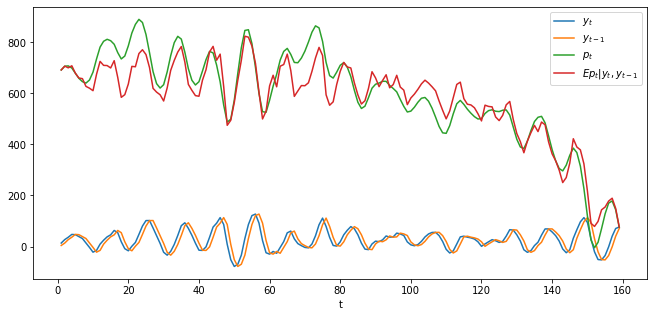

In [80]:
plt.plot(range(1, T), y[1:], label='$y_{t}$')
plt.plot(range(1, T), y[:-1], label='$y_{t-1}$')
plt.plot(range(1, T), p[1:], label='$p_{t}$')
plt.plot(range(1, T), cond_Ep, label='$Ep_{t}|y_{t}, y_{t-1}$')

plt.xlabel('t')
plt.legend(loc=1)
plt.show()

In the above graph, the green line is what the price of the stock would
be if people had perfect foresight about the path of dividends while the
green line is the conditional expectation $E p_t | y_t, y_{t-1}$, which is what the price would
be if people did not have perfect foresight but were optimally
predicting future dividends on the basis of the information
$y_t, y_{t-1}$ at time $t$.

## Filtering Foundations

Assume that $x_0$ is an $n \times 1$ random vector and that
$y_0$ is a $p \times 1$ random vector determined by the
*observation equation*

$$
y_0 = G x_0 + v_0  , \quad x_0 \sim {\mathcal N}(\hat x_0, \Sigma_0), \quad v_0 \sim {\mathcal N}(0, R)
$$

where $v_0$ is orthogonal to $x_0$, $G$ is a
$p \times n$ matrix, and $R$ is a $p \times p$
positive definite matrix.

We consider the problem of someone who 

* *observes* $y_0$
*  does not observe $x_0$,
*  knows $\hat x_0, \Sigma_0, G, R$ and therefore  the joint probability distribution of the vector $\begin{bmatrix} x_0 \cr y_0 \end{bmatrix}$ 
* wants to infer $x_0$ from $y_0$ in light of what he knows about that
joint probability distribution.

Therefore, the person wants to construct the probability distribution of
$x_0$ conditional on the random vector $y_0$.

The joint distribution of
$\begin{bmatrix} x_0 \cr y_0 \end{bmatrix}$ is multivariate normal
${\mathcal N}(\mu, \Sigma)$ with

$$
\mu = \begin{bmatrix} \hat x_0 \cr G \hat x_0 \end{bmatrix} , \quad
  \Sigma = \begin{bmatrix} \Sigma_0 & \Sigma_0 G' \cr
                          G \Sigma_0 & G \Sigma_0 G' + R \end{bmatrix}
$$

By applying an appropriate instance of the above formulas for the  mean vector $\hat \mu_1$ and covariance matrix
$\hat \Sigma_{11}$ of $z_1$ conditional on $z_2$, we find that the probability distribution of
$x_0$ conditional on $y_0$ is
${\mathcal N}(\tilde x_0, \tilde \Sigma_0)$ where

$$
\begin{aligned} \beta_0  & = \Sigma_0 G' (G \Sigma_0 G' + R)^{-1} \cr
\tilde x_0 & = \hat x_0 + \beta_0 ( y_0 - G \hat x_0) \cr
 \tilde \Sigma_0 & = \Sigma_0 - \Sigma_0 G' (G \Sigma_0 G' + R)^{-1} G \Sigma_0
  \end{aligned}
$$

### Step toward dynamics

Now suppose that we are in a time series setting and that we have the
one-step state transition equation

$$
x_1 = A x_0 + C w_1 ,  \quad w_1 \sim {\mathcal N}(0, I )
$$

where $A$ is an $n \times n$ matrix and $C$ is an
$n \times m$ matrix.

It follows that the probability distribution of $x_1$ conditional
on $y_0$ is

$$
x_1 | y_0 \sim {\mathcal N}(A \tilde x_0 , A \tilde \Sigma_0 A' + C C' )
$$

Define

$$
\begin{aligned} \hat x_1 & = A \tilde x_0 \cr
               \Sigma_1 & = A \tilde \Sigma_0 A' + C C'
\end{aligned}
$$

### Dynamic version

Suppose now that for $t \geq 0$,
$\{x_{t+1}, y_t\}_{t=0}^\infty$ are governed by the equations

$$
\begin{aligned}
x_{t+1} & = A x_t + C w_{t+1} \cr
y_t & = G x_t + v_t
\end{aligned}
$$

where as before $x_0 \sim {\mathcal N}(\hat x_0, \Sigma_0)$,
$w_{t+1}$ is the $t+1$th component of an i.i.d. stochastic
process distributed as $w_{t+1} \sim {\mathcal N}(0, I)$, and
$v_t$ is the $t$th component of an i.i.d. process
distributed as $v_t \sim {\mathcal N}(0, R)$ and the
$\{w_{t+1}\}_{t=0}^\infty$ and $\{v_t\}_{t=0}^\infty$
processes are orthogonal at all pairs of dates.

The logic and
formulas that we applied above imply that the probability distribution
of $x_t$ conditional on
$y_0, y_1, \ldots , y_{t-1} = y^{t-1}$ is

$$
x_t | y^{t-1} \sim {\mathcal N}(A \tilde x_t , A \tilde \Sigma_t A' + C C' )
$$

where $\{\tilde x_t, \tilde \Sigma_t\}_{t=1}^\infty$ can be
computed by iterating on the following equations starting from
$t=1$ and initial conditions for
$\tilde x_0, \tilde \Sigma_0$ computed as we have above:

$$
\begin{aligned} \Sigma_t & = A  \tilde \Sigma_{t-1} A' + C C' \cr
               \hat x_t & = A \tilde x_{t-1} \cr
\beta_t & = \Sigma_t G' (G \Sigma_t G' + R)^{-1} \cr
\tilde x_t & = \hat x_t + \beta_t ( y_t - G \hat x_t) \cr
 \tilde \Sigma_t & = \Sigma_t - \Sigma_t G' (G \Sigma_t G' + R)^{-1} G \Sigma_t
  \end{aligned}
$$

If we shift the first equation forward one period and then substitute the expression for $\tilde \Sigma_t$  on the right side of the fifth equation
into it we obtain

$$
\Sigma_{t+1}= C C' + A \Sigma_t A' - A \Sigma_t G' (G \Sigma_t G' +R)^{-1} G \Sigma_t A' . 
$$

This is a matrix Riccati difference equation that is closely related to another matrix Riccati difference equation that appears in  a quantecon lecture on the basics of linear quadratic control theory.

That equation has the form  

  

```{math}

P_{t-1} =R + A' P_t A  - A' P_t B 
(B' P_t B + Q)^{-1}  B' P_t A  .
 
```

Stare at the two preceding equations for a moment or two, the first being a matrix difference equation for a conditional covariance matrix, the
second being a matrix difference equation in the matrix appearing in a quadratic form for an intertemporal cost of value function.

Although the  two equations are not identical, they display striking family resemblences.

* the first equation tells dynamics that work **forward**  in time
* the second equation tells dynamics that work  **backward** in time
* while many of the terms are similar, one equation seems to apply matrix transformations to some matrices that play similar roles in the other equation 

The family resemblences of these two equations reflects a transcendent **duality** between control theory and filtering theory.

### An example



We can use the Python class *MultivariateNormal* to construct examples.

Here is an example for a single period problem at time $0$

In [81]:
G = np.array([[1., 3.]])
R = np.array([[1.]])

x0_hat = np.array([0., 1.])
Σ0 = np.array([[1., .5], [.3, 2.]])

μ = np.hstack([x0_hat, G @ x0_hat])
Σ = np.block([[Σ0, Σ0 @ G.T], [G @ Σ0, G @ Σ0 @ G.T + R]])

In [82]:
# construction of the multivariate normal instance
multi_normal = MultivariateNormal(μ, Σ)

In [83]:
multi_normal.partition(2)

In [84]:
# the observation of y
y0 = 2.3

# conditional distribution of x0
μ1_hat, Σ11 = multi_normal.cond_dist(0, y0)
μ1_hat, Σ11

(array([-0.078125,  0.803125]),
 array([[ 0.72098214, -0.203125  ],
        [-0.403125  ,  0.228125  ]]))

In [85]:
A = np.array([[0.5, 0.2], [-0.1, 0.3]])
C = np.array([[2.], [1.]])

# conditional distribution of x1
x1_cond = A @ μ1_hat
Σ1_cond = C @ C.T + A @ Σ11 @ A.T
x1_cond, Σ1_cond

(array([0.1215625, 0.24875  ]),
 array([[4.12874554, 1.95523214],
        [1.92123214, 1.04592857]]))

### Code for Iterating

Here is code for solving a dynamic filtering problem by iterating on our
equations, followed by an example.

In [86]:
def iterate(x0_hat, Σ0, A, C, G, R, y_seq):

    p, n = G.shape

    T = len(y_seq)
    x_hat_seq = np.empty((T+1, n))
    Σ_hat_seq = np.empty((T+1, n, n))

    x_hat_seq[0] = x0_hat
    Σ_hat_seq[0] = Σ0

    for t in range(T):
        xt_hat = x_hat_seq[t]
        Σt = Σ_hat_seq[t]
        μ = np.hstack([xt_hat, G @ xt_hat])
        Σ = np.block([[Σt, Σt @ G.T], [G @ Σt, G @ Σt @ G.T + R]])

        # filtering
        multi_normal = MultivariateNormal(μ, Σ)
        multi_normal.partition(n)
        x_tilde, Σ_tilde = multi_normal.cond_dist(0, y_seq[t])

        # forecasting
        x_hat_seq[t+1] = A @ x_tilde
        Σ_hat_seq[t+1] = C @ C.T + A @ Σ_tilde @ A.T

    return x_hat_seq, Σ_hat_seq

In [87]:
iterate(x0_hat, Σ0, A, C, G, R, [2.3, 1.2, 3.2])

(array([[0.        , 1.        ],
        [0.1215625 , 0.24875   ],
        [0.18680212, 0.06904689],
        [0.75576875, 0.05558463]]),
 array([[[1.        , 0.5       ],
         [0.3       , 2.        ]],
 
        [[4.12874554, 1.95523214],
         [1.92123214, 1.04592857]],
 
        [[4.08198663, 1.99218488],
         [1.98640488, 1.00886423]],
 
        [[4.06457628, 2.00041999],
         [1.99943739, 1.00275526]]]))

The iterative algorithm just described is a version of the celebrated **Kalman filter**.

We describe the Kalman filter  and some applications of it in {doc}`A First Look at the Kalman Filter <kalman>`


## Classic Factor Analysis Model

The factor analysis model widely used in psychology and other fields can
be represented as

$$
Y = \Lambda f + U
$$

where

1. $Y$ is $n \times 1$ random vector,
   $E U U^{\prime} = D$ is a diagonal matrix,
1. $\Lambda$ is $n \times k$ coefficient matrix,
1. $f$ is $k \times 1$ random vector,
   $E f f^{\prime} = I$,
1. $U$ is $n \times 1$ random vector, and $U \perp f$ (i.e., $E U f' = 0 $ )
1. It is presumed that $k$ is small relative to $n$; often
   $k$ is only $1$ or $2$, as in our IQ examples.

This implies that

$$
\begin{aligned}
\Sigma_y = E Y Y^{\prime} = \Lambda \Lambda^{\prime} + D \\
E Y f^{\prime} = \Lambda \\
E f Y^{\prime} = \Lambda^{\prime}
\end{aligned}
$$

Thus, the covariance matrix $\Sigma_Y$ is the sum of a diagonal
matrix $D$ and a positive semi-definite matrix
$\Lambda \Lambda^{\prime}$ of rank $k$.

This means that all covariances among the $n$ components of the
$Y$ vector are intermediated by their common dependencies on the
$k<$ factors.

Form

$$
Z=\left(\begin{array}{c}
f\\
Y
\end{array}\right)
$$

the covariance matrix of the expanded random vector $Z$ can be
computed as

$$
\Sigma_{z} = EZZ^{\prime}=\left(\begin{array}{cc}
I & \Lambda^{\prime}\\
\Lambda & \Lambda\Lambda^{\prime}+D
\end{array}\right)
$$

In the following, we first construct the mean vector and the covariance
matrix for the case where $N=10$ and $k=2$.

In [88]:
N = 10
k = 2

We set the coefficient matrix $\Lambda$ and the covariance matrix
of $U$ to be

$$
\Lambda=\left(\begin{array}{cc}
1 & 0\\
\vdots & \vdots\\
1 & 0\\
0 & 1\\
\vdots & \vdots\\
0 & 1
\end{array}\right),\quad D=\left(\begin{array}{cccc}
\sigma_{u}^{2} & 0 & \cdots & 0\\
0 & \sigma_{u}^{2} & \cdots & 0\\
\vdots & \vdots & \vdots & \vdots\\
0 & 0 & \cdots & \sigma_{u}^{2}
\end{array}\right)
$$

where the first half of the first column of $\Lambda$ is filled
with $1$s and $0$s for the rest half, and symmetrically
for the second column. 

$D$ is a diagonal matrix with parameter
$\sigma_{u}^{2}$ on the diagonal.

In [89]:
Λ = np.zeros((N, k))
Λ[:N//2, 0] = 1
Λ[N//2:, 1] = 1

σu = .5
D = np.eye(N) * σu ** 2

In [90]:
# compute Σy
Σy = Λ @ Λ.T + D

We can now construct the mean vector and the covariance matrix for
$Z$.

In [91]:
μz = np.zeros(k+N)

Σz = np.empty((k+N, k+N))

Σz[:k, :k] = np.eye(k)
Σz[:k, k:] = Λ.T
Σz[k:, :k] = Λ
Σz[k:, k:] = Σy

In [92]:
z = np.random.multivariate_normal(μz, Σz)

f = z[:k]
y = z[k:]

In [93]:
multi_normal_factor = MultivariateNormal(μz, Σz)
multi_normal_factor.partition(k)

Let’s compute the conditional distribution of the hidden factor
$f$ on the observations $Y$, namely, $f \mid Y=y$.

In [94]:
multi_normal_factor.cond_dist(0, y)

(array([-0.34723794,  0.03874536]),
 array([[0.04761905, 0.        ],
        [0.        , 0.04761905]]))

We can verify that the conditional mean
$E \left[f \mid Y=y\right] = B Y$ where
$B = \Lambda^{\prime} \Sigma_{y}^{-1}$.

In [95]:
B = Λ.T @ np.linalg.inv(Σy)

B @ y

array([-0.34723794,  0.03874536])

Similarly, we can compute the conditional distribution $Y \mid f$.

In [96]:
multi_normal_factor.cond_dist(1, f)

(array([-0.72863238, -0.72863238, -0.72863238, -0.72863238, -0.72863238,
         0.32341248,  0.32341248,  0.32341248,  0.32341248,  0.32341248]),
 array([[0.25, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
        [0.  , 0.25, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
        [0.  , 0.  , 0.25, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
        [0.  , 0.  , 0.  , 0.25, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
        [0.  , 0.  , 0.  , 0.  , 0.25, 0.  , 0.  , 0.  , 0.  , 0.  ],
        [0.  , 0.  , 0.  , 0.  , 0.  , 0.25, 0.  , 0.  , 0.  , 0.  ],
        [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.25, 0.  , 0.  , 0.  ],
        [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.25, 0.  , 0.  ],
        [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.25, 0.  ],
        [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.25]]))

It can be verified that the mean is
$\Lambda I^{-1} f = \Lambda f$.

In [97]:
Λ @ f

array([-0.72863238, -0.72863238, -0.72863238, -0.72863238, -0.72863238,
        0.32341248,  0.32341248,  0.32341248,  0.32341248,  0.32341248])

## PCA and Factor Analysis

To learn about Principal Components Analysis (PCA), please see this lecture {doc}`Singular Value Decompositions <svd_intro>`.

For fun, let’s apply a PCA decomposition
to a covariance matrix $\Sigma_y$ that in fact is governed by our factor-analytic
model.



Technically, this means that the PCA model is misspecified. (Can you
explain why?)

Nevertheless, this exercise will let us study how well the first two
principal components from a PCA can approximate the conditional
expectations $E f_i | Y$ for our two factors $f_i$,
$i=1,2$ for the factor analytic model that we have assumed truly
governs the data on $Y$ we have generated.

So we compute the PCA decomposition

$$
\Sigma_{y} = P \tilde{\Lambda} P^{\prime}
$$

where $\tilde{\Lambda}$ is a diagonal matrix.

We have

$$
Y = P \epsilon
$$

and

$$
\epsilon = P^\prime Y
$$

Note that we will arrange the eigenvectors in $P$ in the
*descending* order of eigenvalues.

In [98]:
𝜆_tilde, P = np.linalg.eigh(Σy)

# arrange the eigenvectors by eigenvalues
ind = sorted(range(N), key=lambda x: 𝜆_tilde[x], reverse=True)

P = P[:, ind]
𝜆_tilde = 𝜆_tilde[ind]
Λ_tilde = np.diag(𝜆_tilde)

print('𝜆_tilde =', 𝜆_tilde)

𝜆_tilde = [5.25 5.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25]


In [99]:
# verify the orthogonality of eigenvectors
np.abs(P @ P.T - np.eye(N)).max()

4.440892098500626e-16

In [100]:
# verify the eigenvalue decomposition is correct
P @ Λ_tilde @ P.T

array([[1.25, 1.  , 1.  , 1.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [1.  , 1.25, 1.  , 1.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [1.  , 1.  , 1.25, 1.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [1.  , 1.  , 1.  , 1.25, 1.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [1.  , 1.  , 1.  , 1.  , 1.25, 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 1.25, 1.  , 1.  , 1.  , 1.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 1.  , 1.25, 1.  , 1.  , 1.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 1.  , 1.  , 1.25, 1.  , 1.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 1.  , 1.  , 1.  , 1.25, 1.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 1.  , 1.  , 1.  , 1.  , 1.25]])

In [101]:
ε = P.T @ y

print("ε = ", ε)

ε =  [-0.81527001  0.09096912 -0.63806359  0.53849323  1.08045405  0.45543264
 -0.60130338  0.39836659  0.43428747 -0.67104174]


In [102]:
# print the values of the two factors

print('f = ', f)

f =  [-0.72863238  0.32341248]


Below we’ll plot several things

- the $N$ values of $y$
- the $N$ values of the principal components $\epsilon$
- the value of the first factor $f_1$ plotted only for the first
  $N/2$ observations of $y$ for which it receives a
  non-zero loading in $\Lambda$
- the value of the second factor $f_2$ plotted only for the final
  $N/2$ observations for which it receives a non-zero loading in
  $\Lambda$

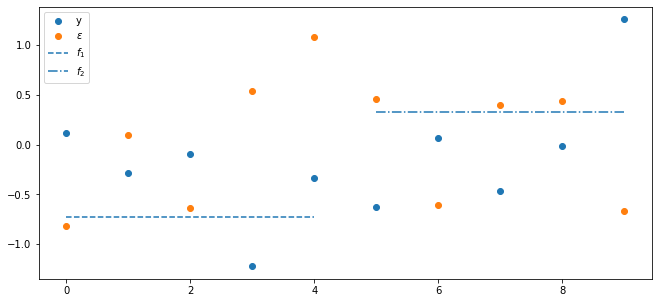

In [103]:
plt.scatter(range(N), y, label='y')
plt.scatter(range(N), ε, label='$\epsilon$')
plt.hlines(f[0], 0, N//2-1, ls='--', label='$f_{1}$')
plt.hlines(f[1], N//2, N-1, ls='-.', label='$f_{2}$')
plt.legend()

plt.show()

Consequently, the first two $\epsilon_{j}$ correspond to the
largest two eigenvalues.

Let’s look at them, after which we’ll look at $E f | y = B y$

In [104]:
ε[:2]

array([-0.81527001,  0.09096912])

In [105]:
# compare with Ef|y
B @ y

array([-0.34723794,  0.03874536])

The fraction of variance in $y_{t}$ explained by the first two
principal components can be computed as below.

In [106]:
𝜆_tilde[:2].sum() / 𝜆_tilde.sum()

0.84

Compute

$$
\hat{Y} = P_{j} \epsilon_{j} + P_{k} \epsilon_{k}
$$

where $P_{j}$ and $P_{k}$ correspond to the largest two
eigenvalues.

In [107]:
y_hat = P[:, :2] @ ε[:2]

In this example, it turns out that the projection $\hat{Y}$ of
$Y$ on the first two principal components does a good job of
approximating $Ef \mid y$.

We confirm this in the following plot of $f$,
$E y \mid f$, $E f \mid y$, and $\hat{y}$ on the
coordinate axis versus $y$ on the ordinate axis.

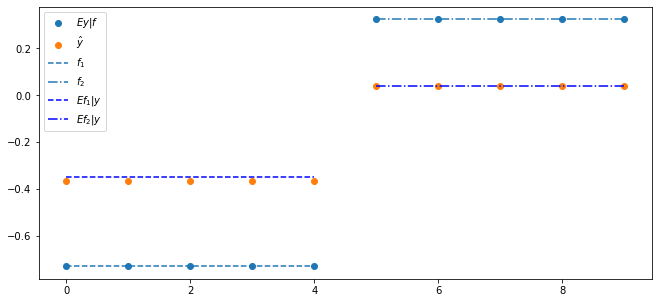

In [108]:
plt.scatter(range(N), Λ @ f, label='$Ey|f$')
plt.scatter(range(N), y_hat, label='$\hat{y}$')
plt.hlines(f[0], 0, N//2-1, ls='--', label='$f_{1}$')
plt.hlines(f[1], N//2, N-1, ls='-.', label='$f_{2}$')

Efy = B @ y
plt.hlines(Efy[0], 0, N//2-1, ls='--', color='b', label='$Ef_{1}|y$')
plt.hlines(Efy[1], N//2, N-1, ls='-.', color='b', label='$Ef_{2}|y$')
plt.legend()

plt.show()

The covariance matrix of $\hat{Y}$ can be computed by first
constructing the covariance matrix of $\epsilon$ and then use the
upper left block for $\epsilon_{1}$ and $\epsilon_{2}$.

In [109]:
Σεjk = (P.T @ Σy @ P)[:2, :2]

Pjk = P[:, :2]

Σy_hat = Pjk @ Σεjk @ Pjk.T
print('Σy_hat = \n', Σy_hat)

Σy_hat = 
 [[1.05 1.05 1.05 1.05 1.05 0.   0.   0.   0.   0.  ]
 [1.05 1.05 1.05 1.05 1.05 0.   0.   0.   0.   0.  ]
 [1.05 1.05 1.05 1.05 1.05 0.   0.   0.   0.   0.  ]
 [1.05 1.05 1.05 1.05 1.05 0.   0.   0.   0.   0.  ]
 [1.05 1.05 1.05 1.05 1.05 0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   1.05 1.05 1.05 1.05 1.05]
 [0.   0.   0.   0.   0.   1.05 1.05 1.05 1.05 1.05]
 [0.   0.   0.   0.   0.   1.05 1.05 1.05 1.05 1.05]
 [0.   0.   0.   0.   0.   1.05 1.05 1.05 1.05 1.05]
 [0.   0.   0.   0.   0.   1.05 1.05 1.05 1.05 1.05]]
